In [1]:
%load_ext autoreload
%autoreload 2

import autograd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
from autograd import grad

import legume
from legume.backend import backend as bd
from legume.optimizers import adam_optimize
from legume.utils import grad_num

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set some global options and parameters

options = {'gmode_inds': np.array([0, 3]),
           'gmode_compute': 'exact',
           'numeig': 10,
           'verbose': False}

lattice = legume.Lattice('square')
path = lattice.bz_path(['X', 'G', 'M'], [20, 20])

eps_b = 12
gmax = 5

In [13]:
def summarize_results(gme):
    """Summarize the results of a gme run.

    Plots the bands and the real space structure
    """
    fig, ax = plt.subplots(1)
    legume.viz.bands(gme, ax=ax, Q=True, cmap='cool')
    gme.phc.plot_overview(cbar=False)

In [14]:
# Function to make a single-layer phc with thickness d and hole radius r
def make_reg(d=0.5, r=0.3):
    """Create the gme object and build the phc with slab thickness d and hole radius r
    """
    phc = legume.PhotCryst(lattice)
    phc.add_layer(d=d, eps_b=eps_b)
    phc.add_shape(legume.Circle(eps=1, r=r))
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    return gme

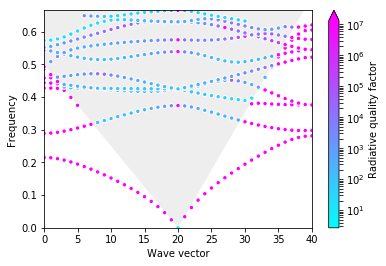

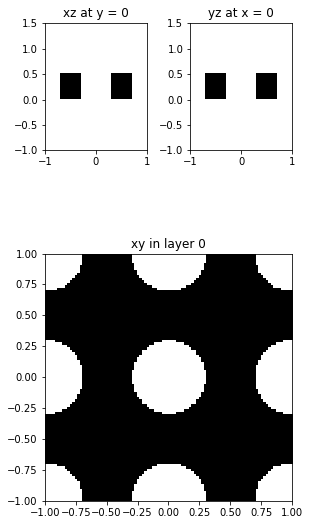

In [15]:
# Test it out
legume.set_backend('numpy')
(d0, r0) = (0.5, 0.3)
gme = make_reg(d0, r0)
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)

In [16]:
# We'll try to force a BIC at a specific k-point in the second band
kind_opt = 15
mind_opt = 1
print("Starting Q: ", gme.freqs[kind_opt, mind_opt]/2/gme.freqs_im[kind_opt, mind_opt])

Starting Q:  246.72611279764612


In [28]:
# Define objective funciton 
def objective(params):
    d = params[0]
    r = params[1]
    gme = make_reg(d, r=r)
    gme.run(kpoints=path.kpoints[:, kind_opt].reshape(2, 1), compute_im=False, **options)

    (freq_im, _, _) = gme.compute_rad(kind=0, minds=[mind_opt])

    # We define the of to be the log of the Q so that it doesn't vary too wildly
    return autograd.numpy.log10(gme.freqs[0, mind_opt]/2/freq_im)
objective_grad = grad(objective)

In [29]:
# Check gradient vs. numerical computation
legume.set_backend('autograd')
print(objective_grad(np.array([d0, r0])))
print(grad_num(objective, np.array([d0, r0])))

[ 0.6516 -2.9412]
[ 0.5483 -2.0080]


At iteration 0 :
Objective value is:   [ 2.3922]
Parameters are:       [ 0.5000  0.3000]
At iteration 1 :
Objective value is:   [ 2.3948]
Parameters are:       [ 0.5010  0.2990]
At iteration 2 :
Objective value is:   [ 2.3974]
Parameters are:       [ 0.5020  0.2980]
At iteration 3 :
Objective value is:   [ 2.4000]
Parameters are:       [ 0.5030  0.2970]
At iteration 4 :
Objective value is:   [ 2.4026]
Parameters are:       [ 0.5040  0.2960]
At iteration 5 :
Objective value is:   [ 2.4052]
Parameters are:       [ 0.5050  0.2950]
At iteration 6 :
Objective value is:   [ 2.4079]
Parameters are:       [ 0.5060  0.2940]
At iteration 7 :
Objective value is:   [ 2.4106]
Parameters are:       [ 0.5070  0.2930]
At iteration 8 :
Objective value is:   [ 2.4133]
Parameters are:       [ 0.5080  0.2920]
At iteration 9 :
Objective value is:   [ 2.4160]
Parameters are:       [ 0.5090  0.2910]
At iteration 10 :
Objective value is:   [ 2.4187]
Parameters are:       [ 0.5100  0.2900]
At iteration 11 :
Ob

At iteration 92 :
Objective value is:   [ 2.8017]
Parameters are:       [ 0.6004  0.2000]
At iteration 93 :
Objective value is:   [ 2.8027]
Parameters are:       [ 0.6016  0.2000]
At iteration 94 :
Objective value is:   [ 2.8038]
Parameters are:       [ 0.6029  0.2000]
At iteration 95 :
Objective value is:   [ 2.8048]
Parameters are:       [ 0.6041  0.2000]
At iteration 96 :
Objective value is:   [ 2.8058]
Parameters are:       [ 0.6054  0.2000]
At iteration 97 :
Objective value is:   [ 2.8068]
Parameters are:       [ 0.6067  0.2000]
At iteration 98 :
Objective value is:   [ 2.8079]
Parameters are:       [ 0.6080  0.2000]
At iteration 99 :
Objective value is:   [ 2.8089]
Parameters are:       [ 0.6092  0.2000]
At iteration 100 :
Objective value is:   [ 2.8100]
Parameters are:       [ 0.6105  0.2000]
At iteration 101 :
Objective value is:   [ 2.8110]
Parameters are:       [ 0.6118  0.2000]
At iteration 102 :
Objective value is:   [ 2.8121]
Parameters are:       [ 0.6131  0.2000]
At iter

At iteration 183 :
Objective value is:   [ 2.9215]
Parameters are:       [ 0.7254  0.2000]
At iteration 184 :
Objective value is:   [ 2.9233]
Parameters are:       [ 0.7269  0.2000]
At iteration 185 :
Objective value is:   [ 2.9251]
Parameters are:       [ 0.7284  0.2000]
At iteration 186 :
Objective value is:   [ 2.9269]
Parameters are:       [ 0.7299  0.2000]
At iteration 187 :
Objective value is:   [ 2.9288]
Parameters are:       [ 0.7314  0.2000]
At iteration 188 :
Objective value is:   [ 2.9306]
Parameters are:       [ 0.7329  0.2000]
At iteration 189 :
Objective value is:   [ 2.9325]
Parameters are:       [ 0.7344  0.2000]
At iteration 190 :
Objective value is:   [ 2.9344]
Parameters are:       [ 0.7359  0.2000]
At iteration 191 :
Objective value is:   [ 2.9363]
Parameters are:       [ 0.7374  0.2000]
At iteration 192 :
Objective value is:   [ 2.9382]
Parameters are:       [ 0.7390  0.2000]
At iteration 193 :
Objective value is:   [ 2.9401]
Parameters are:       [ 0.7405  0.2000]

At iteration 274 :
Objective value is:   [ 3.2444]
Parameters are:       [ 0.8783  0.2000]
At iteration 275 :
Objective value is:   [ 3.2525]
Parameters are:       [ 0.8803  0.2000]
At iteration 276 :
Objective value is:   [ 3.2609]
Parameters are:       [ 0.8823  0.2000]
At iteration 277 :
Objective value is:   [ 3.2696]
Parameters are:       [ 0.8843  0.2000]
At iteration 278 :
Objective value is:   [ 3.2785]
Parameters are:       [ 0.8863  0.2000]
At iteration 279 :
Objective value is:   [ 3.2878]
Parameters are:       [ 0.8884  0.2000]
At iteration 280 :
Objective value is:   [ 3.2974]
Parameters are:       [ 0.8904  0.2000]
At iteration 281 :
Objective value is:   [ 3.3073]
Parameters are:       [ 0.8924  0.2000]
At iteration 282 :
Objective value is:   [ 3.3176]
Parameters are:       [ 0.8945  0.2000]
At iteration 283 :
Objective value is:   [ 3.3283]
Parameters are:       [ 0.8966  0.2000]
At iteration 284 :
Objective value is:   [ 3.3394]
Parameters are:       [ 0.8987  0.2000]

At iteration 365 :
Objective value is:   [ 8.2593]
Parameters are:       [ 0.9970  0.2015]
At iteration 366 :
Objective value is:   [ 10.1761]
Parameters are:       [ 0.9971  0.2012]
At iteration 367 :
Objective value is:   [ 6.4332]
Parameters are:       [ 0.9989  0.2000]
At iteration 368 :
Objective value is:   [ 5.9076]
Parameters are:       [ 1.0004  0.2000]
At iteration 369 :
Objective value is:   [ 5.6099]
Parameters are:       [ 1.0018  0.2000]
At iteration 370 :
Objective value is:   [ 5.4080]
Parameters are:       [ 1.0030  0.2000]
At iteration 371 :
Objective value is:   [ 5.2592]
Parameters are:       [ 1.0041  0.2000]
At iteration 372 :
Objective value is:   [ 5.1440]
Parameters are:       [ 1.0051  0.2000]
At iteration 373 :
Objective value is:   [ 5.0520]
Parameters are:       [ 1.0060  0.2000]
At iteration 374 :
Objective value is:   [ 4.9767]
Parameters are:       [ 1.0068  0.2000]
At iteration 375 :
Objective value is:   [ 4.9142]
Parameters are:       [ 1.0075  0.2000

At iteration 456 :
Objective value is:   [ 4.6071]
Parameters are:       [ 1.0118  0.2008]
At iteration 457 :
Objective value is:   [ 4.6091]
Parameters are:       [ 1.0118  0.2008]
At iteration 458 :
Objective value is:   [ 4.6111]
Parameters are:       [ 1.0118  0.2008]
At iteration 459 :
Objective value is:   [ 4.6132]
Parameters are:       [ 1.0118  0.2008]
At iteration 460 :
Objective value is:   [ 4.6152]
Parameters are:       [ 1.0117  0.2008]
At iteration 461 :
Objective value is:   [ 4.6173]
Parameters are:       [ 1.0117  0.2009]
At iteration 462 :
Objective value is:   [ 4.6193]
Parameters are:       [ 1.0117  0.2009]
At iteration 463 :
Objective value is:   [ 4.6214]
Parameters are:       [ 1.0116  0.2009]
At iteration 464 :
Objective value is:   [ 4.6235]
Parameters are:       [ 1.0116  0.2009]
At iteration 465 :
Objective value is:   [ 4.6256]
Parameters are:       [ 1.0116  0.2010]
At iteration 466 :
Objective value is:   [ 4.6277]
Parameters are:       [ 1.0115  0.2010]

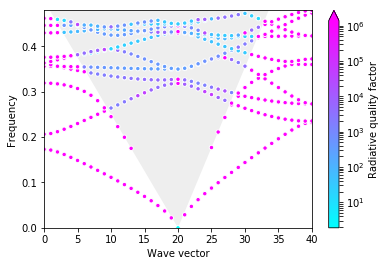

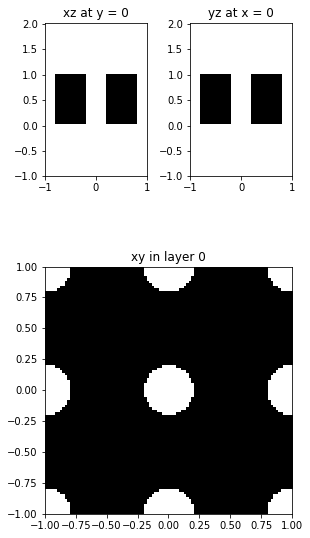

In [41]:
# Run an optimization. We put a lower bound on the radii of 0.2 because otherwise the optimization will just
# try to make a homogeneous slab.

# The optimization is pretty unstable when it gets to very high Q. Maybe an even smaller step size is needed,
# or maybe it's just the fact that the gradient is approximate that becomes important

legume.set_backend('autograd')
(p_opt, ofs) = adam_optimize(objective, np.array([d0, r0]), objective_grad, step_size=0.001, Nsteps=500,
                               options={'direction': 'max', 'disp': ['of', 'params']}, bounds=[0.2, 2])

legume.set_backend('numpy')
gme = make_reg(p_opt[0], p_opt[1])
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)

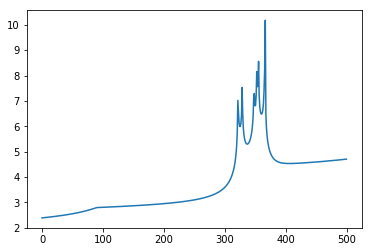

In [42]:
# Plot objective function evolution
plt.plot(ofs)
plt.show()

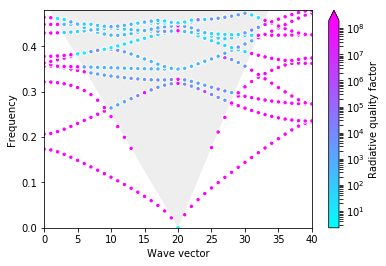

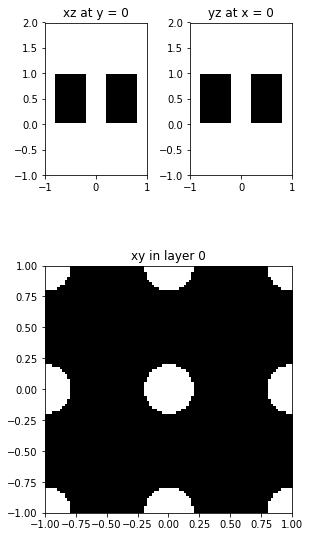

In [45]:
# Plot the best structure that was reached at the course of the optimization
# Beautiful BIC right where we wanted it!
p_max = [0.9969,  0.2010]
gme = make_reg(p_max[0], p_max[1])
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)